In [26]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import math

In [ ]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [202]:
fig_width=6
fig_height=1.5

func_key = "function_name"
dataset_key = "dataset"
dataset_size_key = "dataset_elem_count"
probing_dist_key = "probing_dist"
throughput_key = "throughput" 
order_key = "order"

In [167]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [212]:
def dataset_name(d):
    return {'amzn': "amazon", 
            'fb': "facebook", 
            'gap_10': "gapped 10%",
            'osm': "open street map",
            'seq': "sequential",
            'normal': "normal",
            'uniform': "uniform",
            'wiki': "wikipedia"}[d]

def function_name(f):
    return {'BBHash1' : 'BBHash (overalloc 1)',
             'BBHash2': 'BBHash (overalloc 2)',
             'BitMWHC': 'BitMWHC',
             'CompactTrie': 'Compacted Trie',
             'CompactedCompactTrie': 'Static Compacted Trie',
             'CompactedMWHC': "Compacted MWHC",
             'CompressedMWHC': "Compressed MWHC",
             'CompressedRankHash': "Compressed RankHash",
             'DoNothingHash': "DoNothing",
             'FST': "Fast Succinct Trie",
             'HollowTrie': "Hollow Trie",
             'MWHC': "MWHC",
             'MapOMPHF': "MapOMPHF",
             'RankHash': "RankHash",
             'RecSplit_leaf12_bucket9': "RecSplit",
             'SimpleHollowTrie': "Simple HollowTrie"}[f]

def throughput_order(x):
    return {
        'DoNothingHash': 0,
        'RankHash': 1,
        'CompressedRankHash': 2,
        'MapOMPHF': 3,
        'RecSplit_leaf12_bucket9': 4,
        'BBHash1': 5,
        'BBHash2': 6,
        'CompactTrie': 7,
        'CompactedCompactTrie': 8,
        'SimpleHollowTrie': 9,
        'HollowTrie': 10,
        'FST': 11,
        'MWHC': 12,
        'CompressedMWHC': 13,
        'CompactedMWHC': 14,
        'BitMWHC': 15,
    }[x]

def round_to_nearest_pow_10(num):
    next_smallest = 10**math.floor(math.log10(num))
    return next_smallest * math.ceil(float(num) / float(next_smallest))

In [213]:
results_file = f"../results.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [214]:
th_df = df[(df["name"].str.startswith("LookupTime"))].copy(deep=True)
th_df[func_key] = th_df["label"].apply(lambda x : x.split(":")[0])
th_df[dataset_key] = th_df["label"].apply(lambda x : dataset_name(x.split(":")[1]))
th_df[dataset_size_key] = th_df[dataset_size_key].apply(round_to_nearest_pow_10)
th_df = th_df[th_df[dataset_size_key] >= 10000]
th_df[probing_dist_key] = th_df["label"].apply(lambda x : x.split(":")[2])
th_df[order_key] = th_df[func_key].apply(throughput_order)

empty_th_loop_overheads = th_df[th_df[func_key].str.startswith("DoNothingHash")].groupby([dataset_size_key]).agg({dataset_size_key: 'min', "cpu_time": 'mean'})
def overhead(size):
    return empty_th_loop_overheads[empty_th_loop_overheads[dataset_size_key] == size]["cpu_time"].values[0]

th_df[throughput_key] = th_df.apply(lambda x : 10**9 / (x["cpu_time"] - overhead(x[dataset_size_key])), axis=1)
# th_df[[func_key, "cpu_time", dataset_size_key, throughput_key]]
th_df[[func_key, order_key]]

,function_name,order
14,BBHash1,5
15,BBHash1,5
16,BBHash1,5
17,BBHash1,5
18,BBHash1,5
...,...,...
1428,SimpleHollowTrie,9
1429,SimpleHollowTrie,9
1430,SimpleHollowTrie,9
1431,SimpleHollowTrie,9


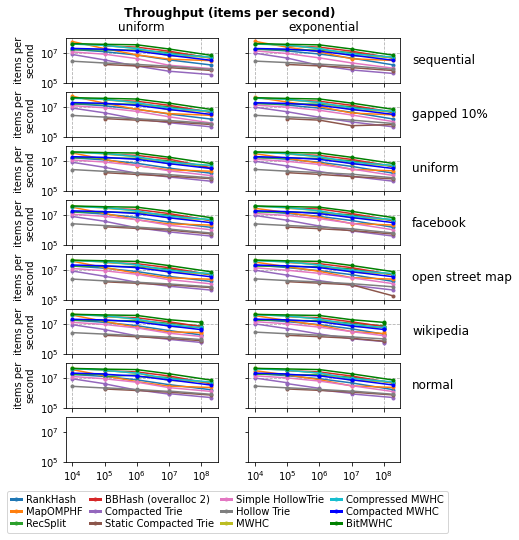

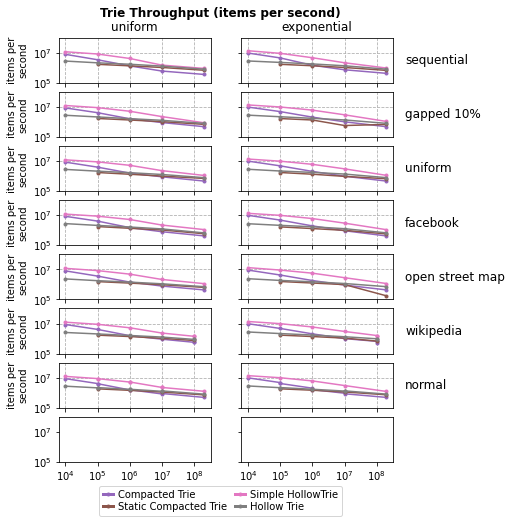

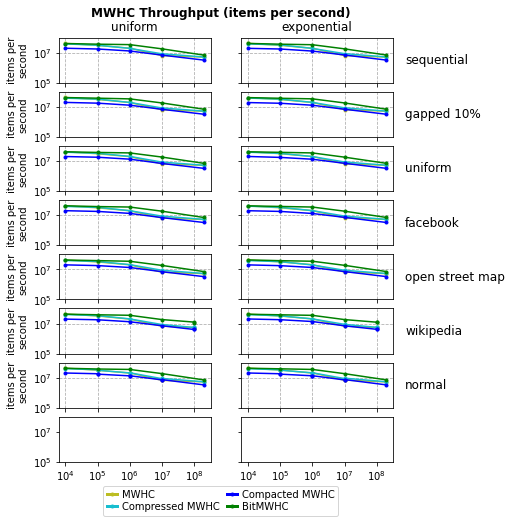

In [218]:
def plot_throughput_deterioration(data, log_scale_y, title_prefix, name_suffix, only_plot=None, ncols=2, yoff=0.02):
    dists = set(data[probing_dist_key])
    
    rows = 8
    cols = len(dists)
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width, rows*fig_height*0.65), sharex=True, sharey=True)

    data = data.sort_values(by=[order_key, dataset_size_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(160 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        axs[i][0].set_ylabel("items per\nsecond")
        for j, (probing_dist, df) in enumerate(df.groupby([probing_dist_key], sort=False)):            
            ax = axs[i][j]

            ax.set_xscale('log')
            if log_scale_y:
                ax.set_yscale('log')
            ax.set_ylim([10**5, 10**8])
            ax.set_xticks([10**i for i in [4, 5, 6, 7, 8, 9]])
#             if i == rows - 1:
#                 ax.set_xlabel("dataset size")
            ax.grid(linestyle="--", axis="both")
    
            for k, (name, df) in enumerate(df.groupby([func_key], sort=False)):
                if only_plot != None and name not in only_plot:
                    continue
                ax.plot(dataset_size_key, throughput_key, data=df, color=get_color(name), label=function_name(name), linewidth=1.5, marker='.')
                
            if i == 0:
                # ax.set_ylabel("normalized entries per slot")
                ax.annotate(probing_dist, 
                            xy=(0.5, 1), 
                            xytext=(0, pad), 
                            xycoords='axes fraction', 
                            textcoords='offset points', 
                            size='large', 
                            ha='center', 
                            va='baseline',
                           )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='lower center',
               bbox_to_anchor=(0.5, yoff),
               ncol=ncols,
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=0.7
              )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
                
    # overall title
    fig.suptitle(f"{title_prefix} Throughput (items per second)", y=0.935, fontweight="bold")
    
    fig.savefig(f"throughput_deterioration_{name_suffix}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"throughput_deterioration_{name_suffix}.pgf", bbox_inches="tight", dpi=300)

reset_colors()
plot_throughput_deterioration(th_df, True, "", "all", [
    # 'BBHash1',
    'BBHash2',
    'BitMWHC',
    'CompactTrie',
    'CompactedCompactTrie',
    'CompactedMWHC',
    'CompressedMWHC',
    # 'CompressedRankHash',
    # 'DoNothingHash',
    'HollowTrie',
    'MWHC',
    'MapOMPHF',
    'RankHash',
    'RecSplit_leaf12_bucket9',
    'SimpleHollowTrie'
], ncols=4, yoff=-0.01)
plot_throughput_deterioration(th_df, True, "Trie", "trie", ["SimpleHollowTrie", "HollowTrie", "CompactTrie", "CompactedCompactTrie", "FastSuccinctTrie"])
plot_throughput_deterioration(th_df, True, "MWHC", "mwhc", ["MWHC", "CompressedMWHC", "CompactedMWHC", "BitMWHC"])